In [22]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

mesh = trimesh.load_mesh("../data/stl/EA-HV_electrode.STL")

In [29]:
mesh.vertices.mean(axis=0)

TrackedArray([227.78855819, 331.2759929 , 339.74896132])

In [23]:
mesh = mesh.subdivide_to_size(1)

In [24]:
areas = mesh.area_faces.tolist()
centroids = mesh.triangles_center.tolist()

In [25]:
from sklearn.cluster import KMeans, BisectingKMeans

kmeans = BisectingKMeans(n_clusters=5000)
clusters = kmeans.fit_predict(centroids, sample_weight=areas)

Text(0, 0.5, 'Number of triangles')

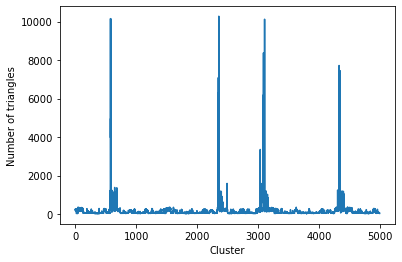

In [26]:
plt.plot(np.unique(clusters, return_counts=True)[1])
plt.xlabel('Cluster')
plt.ylabel('Number of triangles')

In [27]:
import numpy as np
from tqdm import trange

tot_mesh = None
areas = []
for cluster in trange(kmeans.n_clusters):
    submesh = mesh.submesh([np.where(clusters == cluster)[0]], append=True)
    submesh.visual.face_colors = trimesh.visual.random_color()
    areas.append(submesh.area_faces.sum())
    
    # simplify mesh
    submesh.export(f'../data/stl/electrode_stls/5000_parts/cluster_{cluster}.stl')

    if tot_mesh is None:
        tot_mesh = submesh
    else:
        tot_mesh = tot_mesh + submesh
    

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [07:38<00:00, 10.90it/s]


(array([  4.,   0.,   2.,   1.,   1.,   4.,   4.,   4.,   9.,  21.,  38.,
         89., 115., 104.,  80.,  64.,  52.,  54.,  55.,  47.,  49.,  40.,
         56.,  46.,  25.,  11.,   2.,   2.,   4.,   3.,   3.,   2.,   2.,
          1.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 4.86035389,  6.59199689,  8.32363988, 10.05528288, 11.78692588,
        13.51856887, 15.25021187, 16.98185487, 18.71349786, 20.44514086,
        22.17678386, 23.90842685, 25.64006985, 27.37171285, 29.10335584,
        30.83499884, 32.56664184, 34.29828483, 36.02992783, 37.76157083,
        39.49321382, 41.22485682, 42.95649982, 44.68814281, 46.41978581,
        48.15142881, 49.8830718 , 51.6147148 , 53.3463578 , 55.07800079,
        56.80964379, 58.54128679, 60.27292978, 62.00457278, 63.73621578,
        65.46785877, 67.19950177, 68.93114477, 70.66278776, 72.39443076,
        74.12607376, 75.85771675, 77.58935975, 79.32100275, 81.05264574,
 

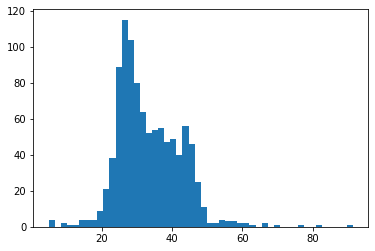

In [19]:
plt.hist(areas, bins=50)

In [14]:
tot_mesh.show()

NameError: name 'tot_mesh' is not defined

In [2]:
stl1 = trimesh.load_mesh('../data/stl/EA-HV_fiber.STL')
stl2 = trimesh.load_mesh('../data/stl/EA-HV_no_electrode.STL')
stl3 = trimesh.load_mesh('../data/stl/EA-HV_fiber_output.stl')

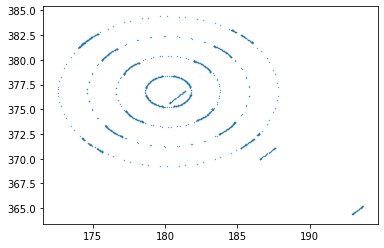

In [3]:
plt.scatter(stl1.triangles_center[:, 0], stl1.triangles_center[:, 1], s=0.1)

(192.92279713948568,
 193.69966990152994,
 339.04451649983724,
 340.19389699300126)

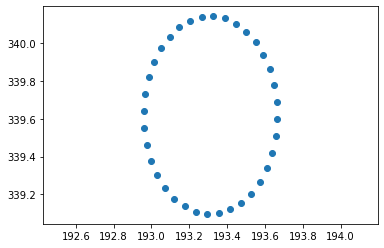

In [4]:
fiber_end = stl1.triangles_center[stl1.triangles_center[:, 0] > 190]
center = np.mean(fiber_end, axis=0)
radius = np.linalg.norm(fiber_end - center, axis=1).max()
plt.scatter(fiber_end[:, 0], fiber_end[:, 2])
# plt.scatter(center[0], center[1], c="r")

# set aspect ratio to be equal
plt.axis("equal")
# plot radius circle
# plt.gca().add_artist(plt.Circle((center[0], center[2]), radius, fill=False, color="r"))

In [5]:
import geometry.utils as gu

pygame 2.5.2 (SDL 2.28.2, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
trimesh.transformations.rotation_matrix(np.pi / 2, [0,1,0], [0,0,0])

array([[ 6.123234e-17,  0.000000e+00,  1.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  1.000000e+00,  0.000000e+00,  0.000000e+00],
       [-1.000000e+00,  0.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [7]:
def cylinder(begin, radius, length, direction):
    # create a cylinder
    cylinder = trimesh.creation.cylinder(radius=radius, height=length)
    cylinder.vertices[:, 2] -= length / 2
    # move the cylinder to the beginning
    # rotate the cylinder to the direction
    rotmat = gu.gen_rot([0, 0, 1], direction)
    transformation_mx = np.eye(4)
    transformation_mx[:3, :3] = rotmat
    cylinder.apply_transform(transformation_mx)

    cylinder.apply_translation(begin)
    return cylinder

In [8]:
verts = stl3.vertices

# get the normal of the plane
normal = np.cross(verts[0] - verts[1], verts[0] - verts[2])
normal /= np.linalg.norm(normal)

# plot cylinder mesh for normal (trimesh). it should start at the center of the fiber end and end at the center of the fiber end + 1mm in the normal direction
cyl = cylinder(center, 0.05, 20, normal)

# set color to red
cyl.visual.face_colors = [255, 0, 0, 255]
(cyl+stl1).show()


In [13]:
import geometry.fiber as fiber

f = fiber.M114L01(position=center, direction=-normal)
phots = f.generate_photons(1000)

# pointcloud
pc = trimesh.points.PointCloud(phots.pos)
# set color to red
pc.colors = list(map(wvl2rgb, np.clip(phots.wavelengths - phots.wavelengths.min() + 380, 380, 780)))

cyls = None
for i,(pos,dir) in enumerate(zip(phots.pos, phots.dir)):
    cyl = cylinder(pos, 0.01, 20, dir)
    cyl.visual.face_colors = pc.colors[i]
    
    if cyls is None:
        cyls = cyl
    else:
        cyls = cyls + cyl


# # create trimesh scene
scene = trimesh.Scene([mesh, stl1, cyls])
scene.show()

In [15]:
-normal

array([-7.36934121e-01,  6.75964569e-01,  5.51121214e-05])

In [59]:
dir

array([-0.6819673 ,  0.72947985,  0.05272296], dtype=float32)

In [9]:
def wvl2rgb(wvl):
    if wvl < 380 or wvl > 780:
        raise ValueError("Wavelength must be between 380 and 780 nm")
    if wvl < 440:
        r = -(wvl - 440) / (440 - 380)
        g = 0.0
        b = 1.0
    elif wvl < 490:
        r = 0.0
        g = (wvl - 440) / (490 - 440)
        b = 1.0
    elif wvl < 510:
        r = 0.0
        g = 1.0
        b = -(wvl - 510) / (510 - 490)
    elif wvl < 580:
        r = (wvl - 510) / (580 - 510)
        g = 1.0
        b = 0.0
    elif wvl < 645:
        r = 1.0
        g = -(wvl - 645) / (645 - 580)
        b = 0.0
    else:
        r = 1.0
        g = 0.0
        b = 0.0
    return np.array([r, g, b])

In [21]:
(stl2.triangles_center.max(axis=0)-stl2.triangles_center.min(axis=0))/2

array([148.96073341, 148.96920268, 265.70482635])